# Model Evaluation

**Notebook 4: Model Evaluation (Validation Set)**

Compares baseline vs feature-enhanced models on the validation set. Evaluates:
- **Precision@K**: accuracy of top-K recommendations
- **Recall@K**: coverage of user's actual preferences in top-K
- **AUC**: ranking quality across all items
- **Reciprocal Rank**: position of first relevant item
- **Item Coverage**: diversity of recommendations

## Init

Load models and rebuild with best hyperparameters for evaluation.

In [1]:
import scipy
import numpy as np
import pandas as pd
import lightfm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from helpers.training import construct_item_features
from lightfm import LightFM
from lightfm import data
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, reciprocal_rank
from lightfm.cross_validation import random_train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from unidecode import unidecode # to deal with accents

/Users/Kitsuragi/Desktop/Code/Brewtiful/.venv/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(
/Users/Kitsuragi/Desktop/Code/Brewtiful/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set random seed for reproducibility
np.random.seed(123)

In [3]:
# Load datasets
train = pd.read_parquet('data/train.parquet', engine='pyarrow')
val = pd.read_parquet('data/val.parquet', engine='pyarrow')
test = pd.read_parquet('data/test.parquet', engine='pyarrow')
filtered = pd.read_parquet('data/filtered.parquet', engine='pyarrow')

In [4]:
# initialize LightFM dataset
light_data = lightfm.data.Dataset()
metadata = list(set(filtered['style'].unique()).union(set(filtered['brewery'].unique())))
light_data.fit(users=filtered['user'].unique(),
               items=filtered['beer_id'].unique(),
               item_features=metadata)
user_mappings = light_data._user_id_mapping
item_mappings = light_data._item_id_mapping
inv_user_mappings = {v:k for k, v in user_mappings.items()}
inv_item_mappings = {v:k for k, v in item_mappings.items()}

In [5]:
# Build interaction matrices
train_interactions = light_data.build_interactions(train[['user', 'beer_id', 'weight_all']].values)

val_interactions = light_data.build_interactions(val[['user', 'beer_id']].values)

In [6]:
# load best hyperparameters for no item features model
with open('artifacts/best_params_no_item_features.pkl', 'rb') as f:
    best_params = pickle.load(f)

In [7]:
# Train base model with best params on training set
best_model = LightFM(**{k: v for k, v in best_params.items() if k != 'epochs'}, random_state=123)
best_model.fit(train_interactions[0], 
               sample_weight=train_interactions[1],
               epochs=best_params['epochs'], 
               verbose=True)

Epoch: 100%|██████████| 48/48 [02:33<00:00,  3.20s/it]


In [8]:
# load best hyperparameters for item features model
with open('artifacts/best_params_with_item_features.pkl', 'rb') as f:
    item_feature_best_params= pickle.load(f)

In [9]:
# Train feature-enhanced model with best params
features = construct_item_features(light_data, filtered, item_feature_best_params['b'], item_feature_best_params['s'])
best_model_item_features = LightFM(**{k: v for k, v in item_feature_best_params.items() if k not in ['epochs', 'b', 's']}, random_state=123)
best_model_item_features.fit(train_interactions[0], 
               sample_weight=train_interactions[1],
               item_features=features,
               epochs=item_feature_best_params['epochs'], 
               verbose=True)

Epoch: 100%|██████████| 46/46 [02:13<00:00,  2.91s/it]


## Offline Metrics

### Popularity Baseline

We'll first consider the naive approach of always recommending the 50 most-reviewed beers and calculate its precision@50 as a baseline comparison.

In [10]:
# Get top 50 most popular items globally
item_popularity = train['beer_id'].value_counts()
top_50_items = item_popularity.head(50).index.tolist()

# For each user in val, check how many of their interactions are in top 10
def popularity_precision_at_k(val_df, top_k_items, k=50):
    precisions = []
    for user in val_df['user'].unique():
        user_items = set(val_df[val_df['user'] == user]['beer_id'])
        hits = len(user_items.intersection(set(top_k_items[:k])))
        precisions.append(hits / k)
    return np.mean(precisions)

popularity_precision_at_k(val, top_50_items, k=50)

np.float64(0.0724097397145256)

In [ ]:
# Print eval metrics for base model
print(auc_score(best_model, val_interactions[0], train_interactions=train_interactions[0]).mean())
print(precision_at_k(best_model, val_interactions[0], k=50, train_interactions=train_interactions[0]).mean())
print(reciprocal_rank(best_model, val_interactions[0], train_interactions=train_interactions[0]).mean())

0.90249646
0.17200673
0.46077484


In [ ]:
# Print eval metrics for features model
print(auc_score(best_model_item_features, val_interactions[0], item_features=features, train_interactions=train_interactions[0]).mean())
print(precision_at_k(best_model_item_features, val_interactions[0], item_features=features, k=50, train_interactions=train_interactions[0]).mean())
print(reciprocal_rank(best_model_item_features, val_interactions[0], item_features=features, train_interactions=train_interactions[0]).mean())

0.9022564
0.17437448
0.46737772


### Model Comparison: Baseline vs Features

| Metric | Base MF | Features |
|--------|----------|----------|
| **AUC** | 0.902 | 0.902 |
| **Precision@50** | 0.172 | 0.174 |
| **Reciprocal Rank** | 0.460 | 0.467 |

The performance of both models is extremely similar across key offline metrics. The high AUC values for both models indicate that the recommender system is good in general at learning user preferences. The precision@50 scores are ~2.37-2.4x better than the the baseline (simple popularity-based recommendation), indicating that personalized recommendations give a substantial improvement. We see that on average, the top 50 recommendations contain ~ 8.6-8.7 interacted-with items, and the MRR tells us that the a relevant item is almost always in the top 2-3 recommended items (closer to 2). These metrics together indicate that meaningful preference signals are being extracted from the embeddings.

### Precision-Recall Trade-off

Next, we'll look at the precision-recall curves of both models across different k values to evaluate their performance.

In [13]:
# Evaluate across multiple K values to understand precision/recall trade-offs
krange = [1,3,5,10,25,50,100,150]

In [14]:
# Calculate precision@K for both models across K values
p_k_data_1 = []
p_k_data_2 = []
for k in krange:
    p_k_data_1.append(precision_at_k(best_model, val_interactions[0], k=k, train_interactions=train_interactions[0]).mean())
    p_k_data_2.append(precision_at_k(best_model_item_features, val_interactions[0],
                                    k=k, train_interactions=train_interactions[0],
                                    item_features=features).mean())

In [15]:
# Calculate recall@K for both models across K values
recall_k_data_1 = []
recall_k_data_2 = []
for k in krange:
    recall_k_data_1.append(recall_at_k(best_model, val_interactions[0], k=k, train_interactions=train_interactions[0]).mean())
    recall_k_data_2.append(recall_at_k(best_model_item_features, val_interactions[0],
                                        k=k, train_interactions=train_interactions[0],
                                        item_features=features).mean())

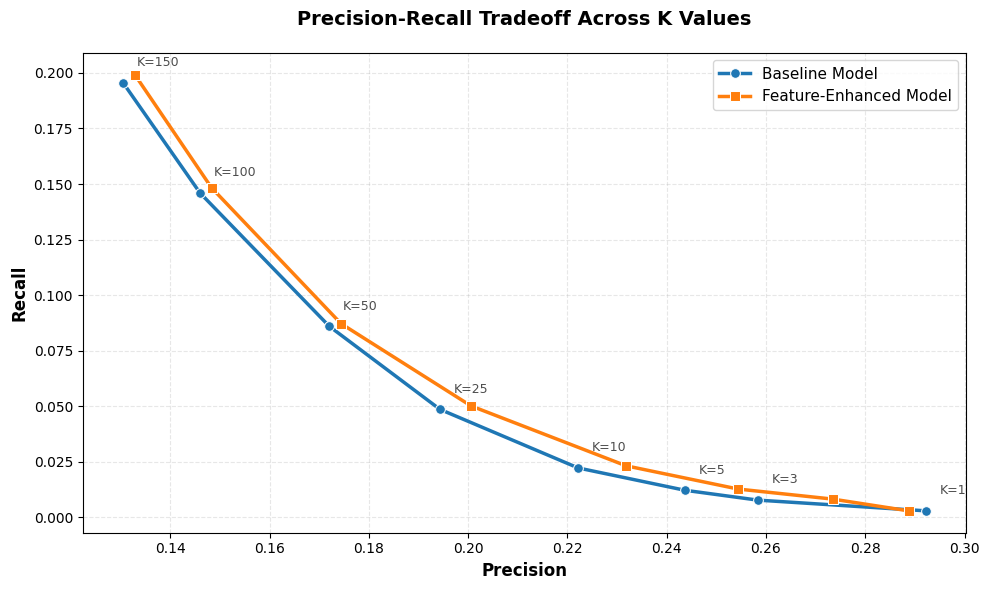

In [43]:
plt.figure(figsize=(10, 6))
plot_data = pd.DataFrame({'precision': p_k_data_1,
                          'recall': recall_k_data_1,
                          'k': krange})
sns.lineplot(plot_data, x='precision', y='recall', label='Baseline Model', marker='o', markersize=7, linewidth=2.5)

# Add K-value labels for each point
for i, k in enumerate(krange):
    plt.annotate(f'K={k}', 
                xy=(p_k_data_1[i], recall_k_data_1[i]), 
                xytext=(10, 12),
                textcoords='offset points',
                fontsize=9,
                alpha=0.7)

plot_data = pd.DataFrame({'precision': p_k_data_2,
                          'recall': recall_k_data_2,
                          'k': krange})
sns.lineplot(plot_data, x='precision', y='recall', label='Feature-Enhanced Model', marker='s', markersize=7, linewidth=2.5)

plt.xlabel('Precision', fontsize=12, fontweight='bold')
plt.ylabel('Recall', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Tradeoff Across K Values', fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

The curves show typical inverse relationship:
- **Low K (K=1)**: High precision (~29%), low recall (~0.001%)
- **High K (K=150)**: Lower precision (~13%), higher recall (~20%)

Both models perform similarly across all K values, suggesting the feature vs non-feature models perform very similarly. The feature-enhanced model consistently performs better, having significantly higher precision and slightly better recall recall across every k value except k=1. This is evidence that the item features are providing a meaningful boost to our recommender.

Note that our production recommender using k-means generates recommendations from across the user's diverse style profiles. The performance of the item feature model at larger k values may indicate that the item feature model will generate better recommendations in the hybrid k-means system - the recommendations being generated by the hybrid model may pull from "further down the list" of the recommendations generated by the standard LightFM model as it prioritizes diversity. If the the feature-enhanced model has better long-tail performance, it may also serve the hybrid system better (but I have no theoretical justification to make this claim).

### Item Coverage

Now, we'll measure item catalog coverage across different k values - the proportion of top-k items the model ever recommends across all users compared to the number of items in the training data set.

In [17]:
# Calculate item coverage: % of catalog recommended across all users
# Important diversity metric - avoid filter bubble effect
from helpers.eval import item_coverage
coverage_data_1 = []
coverage_data_2 = []
for k in krange:
    coverage_data_1.append(item_coverage(best_model, train_interactions[0], k=k))
    coverage_data_2.append(item_coverage(best_model_item_features, train_interactions[0], item_features=features, k=k))

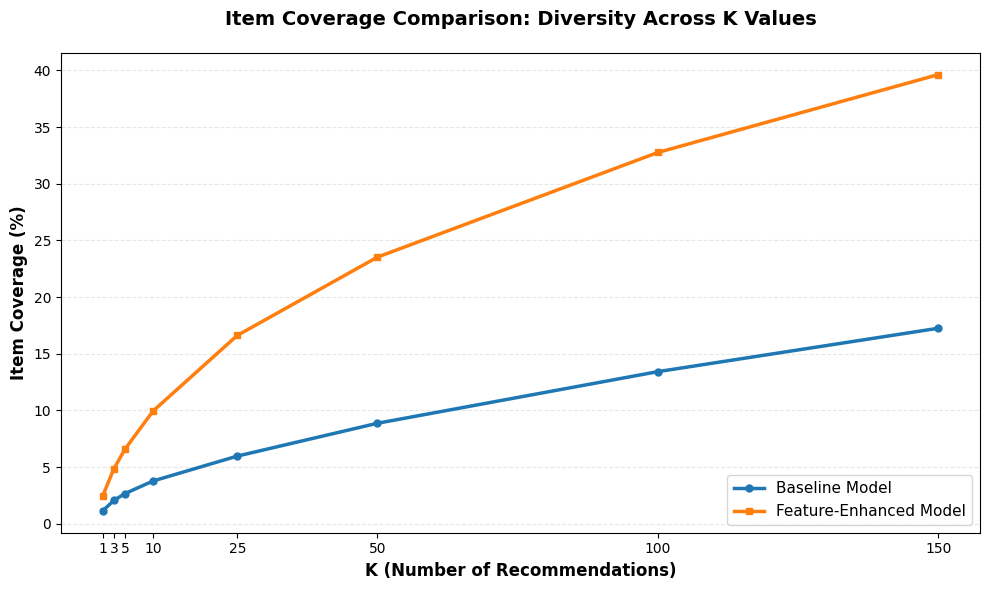

In [44]:
plt.figure(figsize=(10, 6))

# Plot baseline model
plt.plot(krange, [c * 100 for c in coverage_data_1], 
         marker='o', markersize=5, linewidth=2.5, 
         label='Baseline Model')

# Plot feature-enhanced model
plt.plot(krange, [c * 100 for c in coverage_data_2], 
         marker='s', markersize=5, linewidth=2.5, 
         label='Feature-Enhanced Model')

# Add K-value labels on x-axis
plt.xticks(krange, [f'{k}' for k in krange], fontsize=10)

# Labels and formatting
plt.xlabel('K (Number of Recommendations)', fontsize=12, fontweight='bold')
plt.ylabel('Item Coverage (%)', fontsize=12, fontweight='bold')
plt.title('Item Coverage Comparison: Diversity Across K Values', fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()

**The feature model wins decisively on diversity:**
- At K=10: ~10% coverage vs ~4% (~150% improvement)
- At K=100: ~32.5% coverage vs ~14% (~132% improvement)

**This is highly significant for a production recommender system**. Good recommender systems do not only recommend popualr and well-loved items - they recommend personalized items that match the user's genuine preferences. The baseline model will recommend the same popular and well-loved items to everyone, regardless of their preferences. This leads to good offline metrics (popular items ar popular because they are good), but the baseline model ignores the backlog of niche beers waiting to be discovered! The goal of Brewtiful is to create a recommender system built on discovery - the feature model is the clear winner.

## User-Item and Item-Item Recs

### User-Item Recs

Qualitative evaluation: do the recommendations make intuitive sense?

We'll examine two user profiles:
- **User 150**: American IPA and Stout lover
- **User 914**: Pumpkin and wheat beer lover!
  
#### User 150: American IPA and Stout lover

In [61]:
# User 150 profile: beer enthusiast, American IPA and Stout lover
# Varied rating scores, loves double/imperial stouts and hoppy IPAs, several favourite breweries
user=150
train[train['user']==inv_user_mappings[user]].sort_values(by='rating', ascending=False)

,brewery_id,brewery,date,rating,user,style,beer_name,ABV,beer_id,weight_all
8670,1199,Founders Brewing Company,1243039472,5.0,AVDeuph,American Double / Imperial Stout,Founders CBS Imperial Stout,10.60,47658,0.90
8659,1471,Dark Horse Brewing Company,1242096288,5.0,AVDeuph,American Stout,Dark Horse Tres Blueberry Stout,7.50,6227,0.90
8671,1199,Founders Brewing Company,1243040550,5.0,AVDeuph,American Double / Imperial IPA,Founders Hand Of Doom,10.40,47659,0.90
8669,9629,Short's Brewing Company,1242970291,5.0,AVDeuph,Fruit / Vegetable Beer,Short's The Soft Parade,9.00,18021,0.90
8686,287,"Bell's Brewery, Inc.",1268112981,5.0,AVDeuph,American Double / Imperial IPA,Bell's Hopslam Ale,10.00,17112,0.90
8672,3818,Southern Tier Brewing Company,1243306103,4.5,AVDeuph,American Double / Imperial Stout,Choklat,11.00,40058,0.90
8667,1199,Founders Brewing Company,1242876346,4.5,AVDeuph,American Double / Imperial Stout,Founders KBS (Kentucky Breakfast Stout),11.20,19960,0.90
8676,863,Russian River Brewing Company,1243906681,4.5,AVDeuph,American IPA,Blind Pig IPA,6.10,22790,0.90
8684,3818,Southern Tier Brewing Company,1244609279,4.5,AVDeuph,American Double / Imperial Stout,Jahva (Imperial Coffee Stout),10.40,28578,0.90
8657,1471,Dark Horse Brewing Company,1241582654,4.5,AVDeuph,Smoked Beer,Dark Horse Fore Smoked Stout,8.00,7697,0.90


In [62]:
# Baseline model recs for User 150:
# Heavy New Belgium bias (6/10 recs from same brewery user reviewed)
# Shows overfitting to brewery preference without features
from helpers.eval import show_top_items
show_top_items(best_model, train_interactions[0], user, filtered, inv_item_mappings)

,beer_id,beer_name,style,brewery,rating_mean,rating_count
0,11757,Founders Breakfast Stout,American Double / Imperial Stout,Founders Brewing Company,4.351506,2357
1,1093,Two Hearted Ale,American IPA,"Bell's Brewery, Inc.",4.320482,2529
2,15881,Tröegs Nugget Nectar,American Amber / Red Ale,Tröegs Brewing Company,4.385469,1803
3,34146,Founders Double Trouble,American Double / Imperial IPA,Founders Brewing Company,4.101868,1124
4,35036,Founders Backwoods Bastard,Scotch Ale / Wee Heavy,Founders Brewing Company,3.981670,982
5,226,Great Lakes Edmund Fitzgerald Porter,American Porter,Great Lakes Brewing Company,4.322813,1600
6,16074,Founders Red's Rye PA,Rye Beer,Founders Brewing Company,4.206642,1355
7,1444,Bell's Expedition Stout,Russian Imperial Stout,"Bell's Brewery, Inc.",3.952541,1633
8,1558,Dreadnaught IPA,American Double / Imperial IPA,Three Floyds Brewing Co. & Brewpub,4.325492,1424
9,15813,Great Lakes Blackout Stout,Russian Imperial Stout,Great Lakes Brewing Company,4.171706,926


In [64]:
show_top_items(best_model_item_features, train_interactions[0], user, filtered, inv_item_mappings, item_features=features)

,beer_id,beer_name,style,brewery,rating_mean,rating_count
0,11757,Founders Breakfast Stout,American Double / Imperial Stout,Founders Brewing Company,4.351506,2357
1,15881,Tröegs Nugget Nectar,American Amber / Red Ale,Tröegs Brewing Company,4.385469,1803
2,34146,Founders Double Trouble,American Double / Imperial IPA,Founders Brewing Company,4.101868,1124
3,5441,Founders Centennial IPA,American IPA,Founders Brewing Company,4.145270,1332
4,5385,Dark Horse Crooked Tree IPA,American IPA,Dark Horse Brewing Company,3.973759,705
5,21822,Founders Imperial Stout,Russian Imperial Stout,Founders Brewing Company,4.186667,1050
6,16074,Founders Red's Rye PA,Rye Beer,Founders Brewing Company,4.206642,1355
7,17538,Founders Devil Dancer,American Double / Imperial IPA,Founders Brewing Company,3.727805,1025
8,1093,Two Hearted Ale,American IPA,"Bell's Brewery, Inc.",4.320482,2529
9,45073,Plead The 5th Imperial Stout,Russian Imperial Stout,Dark Horse Brewing Company,4.108081,495


In this instance, we see that the recommendations generated by both users are similar. Both models identify that the user is a big fan of Founders Brewing company, with 4/10 and 6/10 items represented in the top 10 being generated for the base and item features model respectively. Both top-10 lists are dominated by stouts and IPAs like we would expect. However, it's worth pointing out that the base model does not recommend any beers from Dark Horse brewing, a brewery that the user had tried and loved several beers from. The feature-enhanced model recommends two slightly more niche beers from Dark Horse - recommendations which are tailored to that user's preferences. The brewery and style embeddings give useful information!

#### User 914: Pumpkin and wheat beer lover!

In [78]:
# User 914 profile: Pumpkin and wheat beer lover!
user=914
train[train['user']==inv_user_mappings[user]].sort_values(by='rating', ascending=False)

,brewery_id,brewery,date,rating,user,style,beer_name,ABV,beer_id,weight_all
75303,261,Cisco Brewers Inc.,1281489416,5.0,BogleHill,Munich Helles Lager,Summer Of Lager,6.25,925,0.90
75317,139,Shipyard Brewing Co.,1285459213,5.0,BogleHill,Pumpkin Ale,Shipyard Smashed Pumpkin (Pugsley's Signature ...,9.00,52248,0.90
75301,222,Brouwerij Duvel Moortgat NV,1281306507,5.0,BogleHill,Belgian Strong Pale Ale,Duvel,8.50,695,0.90
75300,39,Privatbrauerei Franz Inselkammer KG / Brauerei...,1281288600,5.0,BogleHill,Dunkelweizen,Ayinger Ur-Weisse,5.80,135,0.90
75296,29,Anheuser-Busch,1281188234,5.0,BogleHill,Dunkelweizen,Michelob DunkelWeisse,5.50,43929,0.90
75321,213,Narragansett Brewing Co.,1286047901,5.0,BogleHill,Märzen / Oktoberfest,Narragansett Fest,5.50,61577,0.90
75320,18371,Pretty Things Beer & Ale Project,1285980046,5.0,BogleHill,English Pale Ale,Hedgerow Bitter,5.40,61538,0.90
75314,9790,The Duck-Rabbit Craft Brewery,1284831920,5.0,BogleHill,American Brown Ale,Duck-Rabbit Brown Ale,5.60,20206,0.90
75309,335,New Holland Brewing Company,1284161770,4.5,BogleHill,Pumpkin Ale,New Holland Ichabod Ale,5.50,1567,0.90
75282,10097,Harpoon Brewery,1279565771,4.5,BogleHill,American Pale Wheat Ale,Harpoon Ginger Wheat (100 Barrel Series #29),7.00,53941,0.90


We can see that this user loves pumpkin ales and wheat beers of many varieties (dunkelzeizen, hefezeiven, witbier, etc.)! In particular, the user loves Belgian and German-style wheat beers.

In [79]:
# Baseline model recs for User 914:
show_top_items(best_model, train_interactions[0], user, filtered, inv_item_mappings)

,beer_id,beer_name,style,brewery,rating_mean,rating_count
0,30420,Sierra Nevada Torpedo Extra IPA,American IPA,Sierra Nevada Brewing Co.,4.095275,1926
1,276,Sierra Nevada Pale Ale,American Pale Ale (APA),Sierra Nevada Brewing Co.,4.247817,2405
2,131,Ayinger Celebrator Doppelbock,Doppelbock,Privatbrauerei Franz Inselkammer KG / Brauerei...,4.293592,2013
3,1904,Sierra Nevada Celebration Ale,American IPA,Sierra Nevada Brewing Co.,4.162584,2817
4,104,Samuel Adams Boston Lager,Vienna Lager,Boston Beer Company (Samuel Adams),4.038191,2278
5,11757,Founders Breakfast Stout,American Double / Imperial Stout,Founders Brewing Company,4.351506,2357
6,54904,Samuel Adams Noble Pils,Czech Pilsener,Boston Beer Company (Samuel Adams),4.115810,1265
7,731,Weihenstephaner Hefeweissbier,Hefeweizen,Bayerische Staatsbrauerei Weihenstephan,4.506403,1874
8,1881,Samuel Adams Old Fezziwig Ale,Winter Warmer,Boston Beer Company (Samuel Adams),3.809603,1208
9,2093,90 Minute IPA,American Double / Imperial IPA,Dogfish Head Brewery,4.144437,3029


Here we see that the base model has lost the plot! it's essentially acting as an enhanced popularity recommender - it's recommending well-loved and highly-rated items. There is only one wheat beer in the entire top 10, and the recommendations are dominated by popular IPAs.

In [81]:
# Baseline model recs for User 914:
show_top_items(best_model_item_features, train_interactions[0], user, filtered, inv_item_mappings, item_features=features)

,beer_id,beer_name,style,brewery,rating_mean,rating_count
0,731,Weihenstephaner Hefeweissbier,Hefeweizen,Bayerische Staatsbrauerei Weihenstephan,4.506403,1874
1,46290,Jack D'or,Saison / Farmhouse Ale,Pretty Things Beer & Ale Project,4.063008,492
2,50570,Tank 7 Farmhouse Ale,Saison / Farmhouse Ale,Boulevard Brewing Co.,4.120347,403
3,1932,Pumpkinhead Ale,Pumpkin Ale,Shipyard Brewing Co.,2.866460,644
4,28176,Bam Bière,Saison / Farmhouse Ale,Jolly Pumpkin Artisan Ales,3.995362,539
5,318,UFO Hefeweizen,American Pale Wheat Ale,Harpoon Brewery,3.631443,582
6,18975,Oro De Calabaza,Bière de Garde,Jolly Pumpkin Artisan Ales,4.066243,551
7,36333,Saison - Brett,Saison / Farmhouse Ale,Boulevard Brewing Co.,4.306667,450
8,19306,Calabaza Blanca,Witbier,Jolly Pumpkin Artisan Ales,3.989390,377
9,1946,Franziskaner Hefe-Weisse,Hefeweizen,Spaten-Franziskaner-Bräu,4.138638,1439


Here, the item features model displays much better heuristic performance. Note how the beers recommended come from breweries and styles the user knows and loves. Also note how the rating count of the recommended items are lower across the board - the item features are allowing the model to recommend niche items that fit the user's unique tastes!

## Item-Item Recs
Now we'll observe what happens when we look at similar items (this is how the "similar beers" feature is implemented in Brewtiful production). We'll look at the most cosine-similar items, ignoring the bias term (direct embedding similarity).

In [22]:
# Extract item embeddings from baseline model for similarity analysis
b, e = best_model.get_item_representations()

In [23]:
# Extract item embeddings from feature-enhanced model
i_b, i_e = best_model_item_features.get_item_representations(features=features)

### Pliny the Elder (Russian River Brewing Co.)
Pliny the Elder is a highly-regarded beer from Russian River Brewring Co. that has been in prodution for many years. This hoppy double IPA is one of the most popular items from the dataset and has a universally high rating.

In [121]:
# Pliny the Elder item id: 7971
# Get review count and avg rating for Pliny the Elder
(train[train['beer_id']==7971]
 .groupby(['beer_id', 'beer_name', 'brewery', 'style',], as_index=False)['rating']
 .agg(['size', 'mean']))  # size is review count, mean is avg rating

,beer_id,beer_name,brewery,style,size,mean
0,7971,Pliny The Elder,Russian River Brewing Company,American Double / Imperial IPA,2077,4.593163


In [98]:
# Baseline model similar beers to Pliny the Elder:
from helpers.eval import show_beers
from helpers.eval import serve_similar_beers
show_beers(serve_similar_beers(7971, e, item_mappings, inv_item_mappings), train)

,beer_id,beer_name,style,brewery,count,mean
0,3916,AleSmith IPA,American IPA,AleSmith Brewing Company,799,4.300375
1,7284,YuleSmith (Summer),American Double / Imperial IPA,AleSmith Brewing Company,730,4.221918
2,7597,Pure Hoppiness,American Double / Imperial IPA,Alpine Beer Company,464,4.343750
3,9474,Temptation,American Wild Ale,Russian River Brewing Company,695,4.397122
4,12770,Damnation,Belgian Strong Pale Ale,Russian River Brewing Company,741,4.155870
5,22227,Supplication,American Wild Ale,Russian River Brewing Company,845,4.428402
6,22790,Blind Pig IPA,American IPA,Russian River Brewing Company,928,4.362069
7,29619,Sculpin India Pale Ale,American IPA,Ballast Point Brewing Company,1053,4.434473
8,31323,Hop 15,American Double / Imperial IPA,Port Brewing Company / Pizza Port,567,4.060847
9,45653,Consecration,American Wild Ale,Russian River Brewing Company,664,4.295181


The baseline model perfoms well for this item, as it is highly popular. This means the model has a lot of collaborative filtering information - many users have tried this beer, so the model can find many "similar" beers (other beers that users who tried Pliny the Elder rated and enjoyed). The item-item recommendations are qualitatively very reasonable.

In [111]:
# feature-enhanced model similar beers to Pliny the Elder:
show_beers(serve_similar_beers(7971, i_e, item_mappings, inv_item_mappings), train)

,beer_id,beer_name,style,brewery,count,mean
0,9474,Temptation,American Wild Ale,Russian River Brewing Company,695,4.397122
1,12770,Damnation,Belgian Strong Pale Ale,Russian River Brewing Company,741,4.155870
2,13741,Redemption,Belgian Pale Ale,Russian River Brewing Company,309,4.228155
3,13742,Salvation,Belgian Strong Dark Ale,Russian River Brewing Company,274,4.111314
4,20518,Sanctification,American Wild Ale,Russian River Brewing Company,318,4.333333
5,21690,Pliny The Younger,American Double / Imperial IPA,Russian River Brewing Company,496,4.593750
6,22227,Supplication,American Wild Ale,Russian River Brewing Company,845,4.428402
7,22790,Blind Pig IPA,American IPA,Russian River Brewing Company,928,4.362069
8,27992,Beatification,American Wild Ale,Russian River Brewing Company,280,4.325000
9,45653,Consecration,American Wild Ale,Russian River Brewing Company,664,4.295181


Here we see that the the item features are dominating the "similarity" aspect - all the similar beers are also from Russian River Brewing. whether this is desirable behaviour or not depends on the goals of the production system - if the emphasis is true simialrity, then the item model performs better. If the goal is "products that users also liked", then the base model could be seen as better. Since we are implementing a recommendation system to recommend diverse beers, we prefer the behaviour of the item features model as its main goal will be to recommend items that are truly similar, leaving the recommendations model to model users' diverse tastes.

### Kitsilano Maple Cream Ale (Granville Island Brewery)
Next we'll look at Kitsilano Maple Cream Ale, from Granville Island Brewery in Vancouver, British Columbia. This item is much more niche compared to Pliny the Elder., with 35 reviews.

In [122]:
# Pliny the Elder item model id: 9215
# Get review count and avg rating for Pliny the Elder
(train[train['beer_id']==9215]
 .groupby(['beer_id', 'beer_name', 'brewery', 'style',], as_index=False)['rating']
 .agg(['size', 'mean']))  # size is review count, mean is avg rating


,beer_id,beer_name,brewery,style,size,mean
0,9215,Kitsilano Maple Cream Ale,Granville Island Brewery,Cream Ale,35,3.471429


In [123]:
# Baseline similar beers to Kitsilano Maple Cream Ale
show_beers(serve_similar_beers(9215, e, item_mappings, inv_item_mappings), train)

,beer_id,beer_name,style,brewery,count,mean
0,264,Alexander Keith's India Pale Ale,English India Pale Ale (IPA),Alexander Keith's,196,3.084184
1,2045,Traditional Ale,English Brown Ale,Big Rock Brewery,77,3.571429
2,2046,Grasshopper,American Pale Wheat Ale,Big Rock Brewery,91,3.252747
3,2047,Warthog,Cream Ale,Big Rock Brewery,50,3.250000
4,2197,Holsten Premium,German Pilsener,Hanseatische Getränke-Industrie (HGI) Holsten-...,76,3.203947
5,5119,Holsten Festbock,Bock,Hanseatische Getränke-Industrie (HGI) Holsten-...,66,3.393939
6,8012,Hophead India Pale Ale,American IPA,Tree Brewing,89,3.893258
7,8652,Pale Ale,American Pale Ale (APA),Okanagan Spring Brewery,55,3.381818
8,9255,Mt Begbie Cream Ale,Cream Ale,Mt. Begbie Brewing Co.,23,3.891304
9,9444,1516 Bavarian Lager,Munich Helles Lager,Okanagan Spring Brewery,31,3.564516


In [124]:
# Feature model similar beers to Kitsilano Maple Cream Ale
show_beers(serve_similar_beers(9215, i_e, item_mappings, inv_item_mappings), train)

,beer_id,beer_name,style,brewery,count,mean
0,2045,Traditional Ale,English Brown Ale,Big Rock Brewery,77,3.571429
1,2046,Grasshopper,American Pale Wheat Ale,Big Rock Brewery,91,3.252747
2,7700,English Bay Pale Ale,American Pale Ale (APA),Granville Island Brewery,48,3.302083
3,7832,Granville Island Lager,American Pale Lager,Granville Island Brewery,33,3.530303
4,8012,Hophead India Pale Ale,American IPA,Tree Brewing,89,3.893258
5,11158,Cypress Honey Lager,American Adjunct Lager,Granville Island Brewery,24,3.479167
6,20283,Lions Winter Ale,Winter Warmer,Granville Island Brewery,31,3.629032
7,21163,Longboat Double Chocolate Porter,English Porter,Phillips Brewing Company,30,3.616667
8,21164,Amnesiac Double IPA,American Double / Imperial IPA,Phillips Brewing Company,51,3.950980
9,48847,Brockton IPA,American IPA,Granville Island Brewery,23,3.586957


In this case, the item features generate much better "similar beers". Notice that none of the similar beers in the base model are even from Granville Island Brewery! The other breweries in the item features model are also from Vancouver/British Columbia (the same is not true for several of the beers in the base model). In other words, the item feature model similar items are much more likely to be helpful to someone who lives in Vancouver and wants to find beers like the Kitsilano Cream Ale. 

# Conclusion

As has already been mentioned several times, the offline metric evaluation is only of limited usefulness when considering the performance of the production recommender as it uses a fundamentally different prediction method. Based off the metric/qualitative evaluation, **the item features model is the clear winner**. That being said, it's clear that the item feature model encodes useful information to the embeddings. This fact, combined with the cold-start improvements of the item feature model make it the obvious choice to implement in production.